In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Data

In [3]:
df = pd.read_csv("data.csv").drop(columns='article_id')
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9964 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_topic    9964 non-null   object
 1   article_content  9964 non-null   object
dtypes: object(2)
memory usage: 233.5+ KB


# Quick View

In [4]:
topic = df['article_topic'].unique()
topic.sort()
topic # ada 29 kategori

array(['Bisnis', 'Bojonegoro', 'Ekonomi', 'Haji', 'Health', 'Hiburan',
       'Horor', 'Hukum', 'Internasional', 'Jakarta', 'K-Pop', 'KPK',
       'Kesehatan', 'Keuangan', 'Lifestyle', 'MotoGP', 'Obat-obatan',
       'Otomotif', 'Pendidikan', 'Personal', 'Pilgub Jatim', 'Politik',
       'Regional', 'Sains', 'Sejarah', 'Sepak Bola', 'Sports',
       'Teknologi', 'Travel'], dtype=object)

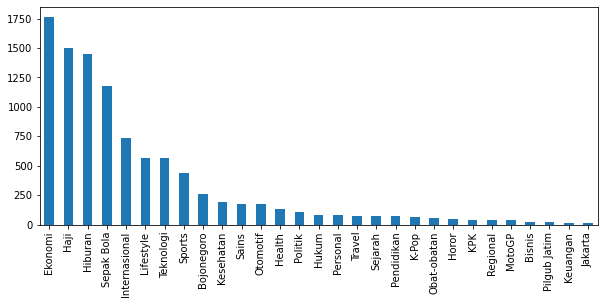

In [5]:
plt.figure(figsize=(10,4))
df.article_topic.value_counts().plot(kind='bar');

# Cleaning Data

membersihkan data dari :
1. punctuation (simbol atau karakter tidak terpakai)
2. url (https atau wwww yang berulang dan tidak dipakai)
3. stopword (kata sambung, awalan, akhiran yang berulang dan tidak bermakna)

In [6]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
def hapus_url(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def hapus_punct(text):
    translator = str.maketrans("","", string.punctuation)
    return text.translate(translator)

stop = set(stopwords.words('indonesian'))
def hapus_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def clean_text(text):
    text = hapus_url(text)
    text = hapus_punct(text)
    text = hapus_stopwords(text)
    return text

In [8]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter_before = counter_word(df.article_content)

print('jumlah karakter sebelum dibersihkan ; ' , len(counter_before))

jumlah karakter sebelum dibersihkan ;  248424


In [9]:
# menghapus stopword, url & punctuation
df['article_content'] = df.article_content.apply(clean_text)

In [10]:
counter_after = counter_word(df.article_content)

print('jumlah karakter setelah dibersihkan ; ' , len(counter_after))

jumlah karakter setelah dibersihkan ;  147340


In [11]:
# melihat text yang terlah diberishkan
df['article_content'].head()

0    kepolisian inggris memburu pelaku meledakkan b...
1    layanan transaksi jalan tol sistem nontunai ok...
2    rabu 238 spesial tagar hashtag 23 agustus mena...
3    indonesia memiliki cadangan bahan bakar minyak...
4    selasa 18 pedangdut ridho rhoma menjalani sida...
Name: article_content, dtype: object

In [12]:
# 5 kata yang paling serting muncul
counter_after.most_common(5)

[('indonesia', 12228),
 ('haji', 10773),
 ('2017', 8954),
 ('orang', 7227),
 ('jemaah', 7214)]

# Encode Label (Topic)

In [13]:
dict = {'Bisnis':1, 'Bojonegoro':2, 'Ekonomi':3, 'Haji':4, 'Health':5, 'Hiburan':6,
       'Horor':7, 'Hukum':8, 'Internasional':9, 'Jakarta':10, 'K-Pop':11, 'KPK':12,
       'Kesehatan':13, 'Keuangan':14, 'Lifestyle':15, 'MotoGP':16, 'Obat-obatan':17,
       'Otomotif':18, 'Pendidikan':19, 'Personal':20, 'Pilgub Jatim':21, 'Politik':22,
       'Regional':23, 'Sains':24, 'Sejarah':25, 'Sepak Bola':26, 'Sports':27,
       'Teknologi':28, 'Travel':29}

In [14]:
df = df.replace({"article_topic": dict})
df.head()

,article_topic,article_content
0,9,kepolisian inggris memburu pelaku meledakkan b...
1,3,layanan transaksi jalan tol sistem nontunai ok...
2,28,rabu 238 spesial tagar hashtag 23 agustus mena...
3,3,indonesia memiliki cadangan bahan bakar minyak...
4,6,selasa 18 pedangdut ridho rhoma menjalani sida...


In [15]:
text = df['article_content'].values.tolist()
label = df['article_topic'].values

# Vectorizer (Content)

mengubah data text menjadi bentuk vektor

In [16]:
tfidf_vectorizer = TfidfVectorizer().fit(text)
tfidf_text = tfidf_vectorizer.transform(text)

# Split data train & test

In [17]:
X_train,X_test,y_train,y_test = train_test_split(tfidf_text,label, test_size= 0.2,random_state= 2)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((7971, 147304), (1993, 147304), (7971,), (1993,))

# Train Models

In [19]:
model = LogisticRegression(multi_class='multinomial',solver='newton-cg',max_iter=300,penalty="l2").fit(X_train,y_train)
pred_LR = model.predict(X_test)

print("Test Accuracy: %.4f" % metrics.accuracy_score(pred_LR, y_test))
print(metrics.classification_report(pred_LR, y_test, target_names=topic))

Test Accuracy: 0.8144
               precision    recall  f1-score   support

       Bisnis       0.00      0.00      0.00         0
   Bojonegoro       0.89      0.91      0.90        44
      Ekonomi       0.98      0.80      0.88       438
         Haji       0.99      0.98      0.99       286
       Health       0.25      0.50      0.33        14
      Hiburan       0.97      0.70      0.81       400
        Horor       0.00      0.00      0.00         0
        Hukum       0.21      1.00      0.35         3
Internasional       0.84      0.80      0.82       168
      Jakarta       0.00      0.00      0.00         0
        K-Pop       0.00      0.00      0.00         0
          KPK       0.83      1.00      0.91         5
    Kesehatan       0.50      0.38      0.43        40
     Keuangan       0.00      0.00      0.00         0
    Lifestyle       0.74      0.71      0.72       116
       MotoGP       0.12      1.00      0.22         1
  Obat-obatan       0.00      0.00      0.

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']

# Test Model


In [23]:
joblib_model = joblib.load('model.pkl')

In [25]:
def prediksi(text):
    text = clean_text(text)
    tfidf_vector = tfidf_vectorizer.transform([text])
    pred = joblib_model.predict(tfidf_vector)
    
    if pred == 1: 
        article_topic = 'Bisnis'
    elif pred == 2: 
        article_topic = 'Bojonegoro'
    elif pred == 3: 
        article_topic = 'Ekonomi'
    elif pred == 4: 
        article_topic = 'Haji'
    elif pred == 5: 
        article_topic = 'Health'
    elif pred == 6: 
        article_topic = 'Hiburan'
    elif pred == 7: 
        article_topic = 'Horor'
    elif pred == 8: 
        article_topic = 'Hukum'
    elif pred == 9: 
        article_topic = 'Internasional'        
    elif pred ==10:
        article_topic = 'Jakarta'
    elif pred ==11: 
        article_topic = 'K-Pop'
    elif pred ==12: 
        article_topic = 'KPK'
    elif pred ==13: 
        article_topic = 'Kesehatan'
    elif pred ==14: 
        article_topic = 'Keuangan'
    elif pred ==15: 
        article_topic = 'Lifestyle'
    elif pred ==16: 
        article_topic = 'MotoGP'
    elif pred ==17: 
        article_topic = 'Obat-obatan'
    elif pred ==18: 
        article_topic = 'Otomotif'        
    elif pred ==19:
        article_topic = 'Pendidikan'
    elif pred ==20:
        article_topic = 'Personal'
    elif pred ==21: 
        article_topic = 'Pilgub Jatim'
    elif pred ==22: 
        article_topic = 'Politik'
    elif pred ==23: 
        article_topic = 'Regional'
    elif pred ==24: 
        article_topic = 'Sains'
    elif pred ==25: 
        article_topic = 'Sejarah'
    elif pred ==26: 
        article_topic = 'Sepak Bola'
    elif pred ==27: 
        article_topic = 'Sports'
    elif pred ==28: 
        article_topic = 'Teknologi'        
    elif pred ==29:
        article_topic = 'Travel'
    else:
        article_topic = 'Tidak Ada'
    return article_topic


## Single Testing

In [26]:
test1 = 'Anggota Tim Pembimbing Ibadah Haji Indonesia (TPIHI) Sektor 7, Rizhy Firmansyah menyebutkan, jamaah haji yang memilih tarwiyah dikenakan biaya SAR250 oleh maktab. Fasilitas yang diperoleh berupa transportasi ke Mina dan dari Mina menuju Arafah. Peserta juga akan mendapatkan makan sebanyak dua kali.'
test1

'Anggota Tim Pembimbing Ibadah Haji Indonesia (TPIHI) Sektor 7, Rizhy Firmansyah menyebutkan, jamaah haji yang memilih tarwiyah dikenakan biaya SAR250 oleh maktab. Fasilitas yang diperoleh berupa transportasi ke Mina dan dari Mina menuju Arafah. Peserta juga akan mendapatkan makan sebanyak dua kali.'

In [27]:
prediksi(test1)

'Haji'

In [28]:
test2 = "Gol Chelsea tercipta via Mason Mount (70'). Sementara Everton membalas lewat gol Jarrad Branthwaite (74'). Hasil ini membuat Chelsea harus puas di peringkat ketiga klasemen dengan 37 poin, sementara Everton ada di nomor 14 berkat koleksi 19 angka.Chelsea tampil mendominasi di laga ini. Tetapi, mereka kesulitan mengalahkan kiper Jordan Pickford untuk mencetak gol. Pickford sendiri mencatatkan sembilan penyelamatan di laga tadi."
test2

"Gol Chelsea tercipta via Mason Mount (70'). Sementara Everton membalas lewat gol Jarrad Branthwaite (74'). Hasil ini membuat Chelsea harus puas di peringkat ketiga klasemen dengan 37 poin, sementara Everton ada di nomor 14 berkat koleksi 19 angka.Chelsea tampil mendominasi di laga ini. Tetapi, mereka kesulitan mengalahkan kiper Jordan Pickford untuk mencetak gol. Pickford sendiri mencatatkan sembilan penyelamatan di laga tadi."

In [29]:
prediksi(test2) # prediksi label

'Sepak Bola'

In [30]:
test3 ="Hal itu ia ungkapkan menanggapi hasil rapat Komisi XI dengan Kementerian Keuangan pada Rabu (15/12) yang membahas tentang Tambahan PMN 2021 dan PMN 2022. Dari rapat itu terungkap Tambahan PMN 2021 masing-masing untuk Hutama Karya Rp 9,1 triliun, Waskita Karya Rp 7,9 triliun, Kereta Api Indonesia Rp 6,9 triliun, Badan Bank Tanah Rp 1 triliun, Indonesia Investment Authority Rp 15 triliun, dan Lembaga Manajemen Aset Negara Rp 3,3 triliun. Totalnya, tambahan PMN 2021 ini mencapai Rp 43,2 triliun. Salah satu persoalan PMN yang sempat ramai adalah ketika PT KAI mendapatkan tambahan modal negara untuk proyek Kereta Cepat Jakarta-Bandung (KCJB) Rp 4,3 triliun. Manajemen KAI menyebut, total kebutuhan biaya proyek tersebut Rp 6,9 triliun."
test3

'Hal itu ia ungkapkan menanggapi hasil rapat Komisi XI dengan Kementerian Keuangan pada Rabu (15/12) yang membahas tentang Tambahan PMN 2021 dan PMN 2022. Dari rapat itu terungkap Tambahan PMN 2021 masing-masing untuk Hutama Karya Rp 9,1 triliun, Waskita Karya Rp 7,9 triliun, Kereta Api Indonesia Rp 6,9 triliun, Badan Bank Tanah Rp 1 triliun, Indonesia Investment Authority Rp 15 triliun, dan Lembaga Manajemen Aset Negara Rp 3,3 triliun. Totalnya, tambahan PMN 2021 ini mencapai Rp 43,2 triliun. Salah satu persoalan PMN yang sempat ramai adalah ketika PT KAI mendapatkan tambahan modal negara untuk proyek Kereta Cepat Jakarta-Bandung (KCJB) Rp 4,3 triliun. Manajemen KAI menyebut, total kebutuhan biaya proyek tersebut Rp 6,9 triliun.'

In [31]:
prediksi(test3) # prediksi label

'Ekonomi'